I. Introduction - - - - 
Domain-specific area 
Objectives 
Dataset Description 
Evaluation methodology 


II. Implementation - - - - 
Data Preprocessing 
Baseline Performance 
Comparative Classification methodology 
Programming style 


III. Conclusions - - 
Performance Analysis & Comparative Discussion 
Project Summary and Reflections 

# CM3060 Natural Language Processing - Coursework
# Sentiment Analysis: Comparing Statistical and Embedding-Based Models

## 1. Domain-Specific Area

Sentiment analysis is the process of determining whether a piece of text expresses positive or negative sentiment. It has become common as more people share opinions online through reviews, social media, and forums. Companies use it to understand customer feedback, and researchers use it to study public opinion on various topics.

The commercial uses are straightforward. Businesses analyze product reviews to see what customers like or dislike. Online retailers like Amazon process millions of reviews to highlight helpful feedback and identify product issues [1]. Social media companies use sentiment analysis to understand user reactions to content. In finance, some investors analyze news sentiment to inform trading decisions [2]. The market for these tools has grown as text data has become more abundant.

Movie reviews are a common testing ground for sentiment analysis methods. Review sites like IMDB and Rotten Tomatoes contain large volumes of labeled data where users rate movies and write text reviews. This makes them useful for training and testing classification models. Movie reviews also present some interesting problems. People use sarcasm, make comparisons to other films, and sometimes give mixed opinions in a single review. For example, a reviewer might describe a villain as "terrific," which is a positive word used in a negative context, or they might say a movie was "not bad," which a simple word-counting program might misinterpret. These patterns make movie sentiment analysis more difficult than it might first appear [3].

The field has seen two main approaches over the years. Traditional methods use statistical features like word frequencies and work well for many tasks. They are fast to train and easy to understand. More recent deep learning methods use neural networks and pre-trained language models. These can capture more nuanced patterns but require more computational resources and training time [4].

This project compares both approaches on the IMDB movie review dataset. The dataset contains 50,000 reviews with a perfect 50/50 split between positive and negative examples. This balanced distribution makes it a fair test for comparing different models. The goal is to see how much improvement modern methods provide over traditional ones, and whether that improvement is worth the extra complexity.

**References:**
[1] Pang, B., & Lee, L. (2008). Opinion mining and sentiment analysis. Foundations and Trends in Information Retrieval, 2(1-2), 1-135.  
[2] Bollen, J., Mao, H., & Zeng, X. (2011). Twitter mood predicts the stock market. Journal of Computational Science, 2(1), 1-8.  
[3] Liu, B. (2012). Sentiment Analysis and Opinion Mining. Morgan & Claypool Publishers.  
[4] Devlin, J., et al. (2019). BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding. NAACL-HLT.  



## 2. Objectives

The primary objective of this project is to implement and compare two different approaches to text classification: a traditional statistical model and a modern deep learning model. I am not trying to invent a new algorithm, but rather to apply existing standard tools to see how they perform on a clean dataset. The goal is to understand the practical tradeoffs between using a simple, fast model and a complex, slower one.

My first specific goal is to create a baseline using standard machine learning methods. I will use Logistic Regression with a Bag of Words approach as an initial baseline, then implement TF-IDF with Naive Bayes as the main statistical model. This approach has been used for text classification for decades and still works reasonably well for many tasks [1]. It is fast to train and does not require special hardware like GPUs. By measuring how well this baseline performs, I can determine whether fancier methods provide meaningful improvements.

My second goal is to implement an embedding-based model using DistilBERT. This is a smaller version of BERT that still captures contextual information from text [2]. Unlike TF-IDF which treats words independently, BERT-style models understand how words relate to each other in context. The model comes pre-trained on large amounts of text, which means it already knows general language patterns before I fine-tune it on movie reviews. This transfer learning approach has become standard in recent years [3].

The comparison will focus on standard classification metrics: accuracy, precision, recall, and F1-score. These metrics show different aspects of model performance and are commonly used in sentiment analysis research. I will also compare training time and resource requirements. The BERT model takes much longer to train and benefits from GPU acceleration, while Naive Bayes trains in seconds on a regular CPU. To support this, I have written code that automatically detects available hardware and adjusts training parameters accordingly, which helps make the project reproducible on different machines and to utilize my 3090 to speed up training.

The results should show whether the performance gains from deep learning are worth the extra computational cost and whether the simpler statistical approach remains competitive for this type of task.

**References:**
[1] Manning, C. D., et al. (2008). Introduction to Information Retrieval. Cambridge University Press.  
[2] Sanh, V., et al. (2019). DistilBERT, a distilled version of BERT. arXiv:1910.01108.  
[3] Devlin, J., et al. (2019). BERT: Pre-training of Deep Bidirectional Transformers. NAACL-HLT.  

In [ ]:
%pip install datasets matplotlib pandas seaborn scikit-learn nltk  

import sys
import subprocess
import importlib.util

#We have to install the right torch based on your hardware if we want GPU speed up, which I do as I have 3090 specifically for the speed up.
def has_nvidia_gpu():
	#This makes it easier to do branching
	try:
		# -L lists devices. If this succeeds, we have an NVIDIA GPU.
		subprocess.check_output(['nvidia-smi', '-L'])
		return True
	except (FileNotFoundError, subprocess.CalledProcessError):
		return False

if not importlib.util.find_spec("torch"):
	print("PyTorch not found. Checking if there is a compatible GPU. ")

	if has_nvidia_gpu():
		print("NVIDIA GPU detected. Installing CUDA-enabled PyTorch.")
		print("This takes a while, like 20 minutes. Please be patient.")
		
		# Can't use %pip inside python calls, this is the next best thing. 
		subprocess.check_call([sys.executable, "-m", "pip", "install", "torch", "torchvision", "torchaudio", "accelerate", "--index-url", "https://download.pytorch.org/whl/cu124"])
	else:
		print("No dedicated NVIDIA GPU detected. Installing the basic CPU-optimized PyTorch.")
		# Can't use %pip inside python calls, this is the next best thing. 
		subprocess.check_call([sys.executable, "-m", "pip", "install", "torch", "torchvision", "torchaudio", "accelerate"])

Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip install transformers  
#We install transformers here, because it can import torch on it's own, which would be CPU by default
import torch
#And checks the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device Available: ", str(device).upper())
if device.type == "cuda":
	print("GPU Name: ", torch.cuda.get_device_name(0))
	vram = round(torch.cuda.get_device_properties(0).total_memory / 1e9,2)
	print("VRAM: ",vram, " GB")

Device Available:  CPU


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import torch
import os

from datasets import load_dataset, Dataset
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback

print("Installed and imported modules")

Installed and imported modules


In [10]:
nltk.download("stopwords")
nltk.download("punkt")
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/codespace/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [5]:
dataset = load_dataset("imdb")
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [ ]:
train_df = pd.DataFrame(dataset["train"])
test_df = pd.DataFrame(dataset["test"])

Ok, let's look at this dataset.

In [8]:
print("Train size:", len(train_df))
print("Test size:", len(test_df))
print("\nClass distribution in training set:")
print(train_df["label"].value_counts())
print("\nClass distribution in test set:")
print(test_df["label"].value_counts())


print("\nReview #1:")
print(train_df.iloc[0]["text"][:500])
print("\nLabel:", train_df.iloc[0]["label"], "(0=negative, 1=positive)")

Train size: 25000
Test size: 25000

Class distribution in training set:
label
0    12500
1    12500
Name: count, dtype: int64

Class distribution in test set:
label
0    12500
1    12500
Name: count, dtype: int64

Review #1:
I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attent

Label: 0 (0=negative, 1=positive)


## 3. Dataset Description

For this project, I am using the IMDB Large Movie Review Dataset, which was originally collected by researchers at Stanford University and is now widely available through platforms like Kaggle and the Hugging Face datasets library [1]. This dataset has become a standard benchmark for sentiment analysis research because it is large, clean, and well-balanced.

The dataset contains 50,000 movie reviews total, divided into three subsets: a training set, a test set, and an unsupervised set. For this supervised learning project, I am focusing exclusively on the training and test sets, each containing 25,000 labeled reviews. Each review is labeled as either positive (label 1) or negative (label 0) based on the rating the reviewer gave the movie. Reviews with ratings of 7 or higher are considered positive, while reviews with ratings of 4 or lower are considered negative.

A useful feature of this dataset is its perfect class balance. As my exploration of the data confirmed, the training set contains exactly 12,500 negative reviews and 12,500 positive reviews. The test set follows the same distribution. This balance eliminates the problem of class imbalance, where a model might achieve high accuracy simply by guessing the most common class. In this case, a random guess would yield 50% accuracy, so any performance significantly above that indicates the model is actually learning from the text.

The data consists of two features: the raw text of the review and the corresponding numerical label. The text data is relatively messy and varies in length. For instance, the first review in the training set discusses a film titled I Am Curious-Yellow. The raw text includes HTML tags like ‘<br /><br />’, capitalization for emphasis, and punctuation. This confirms the need for a preprocessing step to clean the data before feeding it into the models. Reviews range from just a few sentences to several paragraphs, which is realistic and makes the dataset more interesting than cleaned or artificial text.

The dataset is available from multiple sources including Kaggle (https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews) and the original Stanford repository (https://ai.stanford.edu/~amaas/data/sentiment/) as well as the datasets library where you can import it directly with load_dataset.  The fact that this dataset has been used in many published papers also makes it easy to compare my results to existing benchmarks.

**References:**  
[1] Maas, A. L., Daly, R. E., Pham, P. T., Huang, D., Ng, A. Y., & Potts, C. (2011). Learning Word Vectors for Sentiment Analysis. Proceedings of the 49th Annual Meeting of the Association for Computational Linguistics: Human Language Technologies, 142-150.  


## 4. Evaluation Methodology

To measure the performance of the models, I will use four standard classification metrics: accuracy, precision, recall, and F1-score. These metrics are commonly used in sentiment analysis research and provide different perspectives on model performance [1].

Accuracy is the primary metric I will use since the IMDB dataset is perfectly balanced. It provides a simple percentage of how many reviews the model classified correctly out of the total. For example, if a model correctly classifies 21,250 out of 25,000 reviews, its accuracy is 85%. In a balanced dataset like this, accuracy is a reliable indicator of overall performance. If the dataset were imbalanced, accuracy could be misleading, but with a 50/50 split, it gives a fair measure.

However, accuracy alone does not tell the whole story. Precision measures reliability. It tells us that when the model predicts a review is positive, how often it is actually positive. If a model labels 10,000 reviews as positive and 8,500 of them are truly positive, then precision is 85%. Recall measures coverage. It tells us how many of the actual positive reviews the model managed to find. If there are 12,500 positive reviews and the model correctly identifies 10,625 of them, then recall is 85%. These two metrics are often in tension with each other. Improving one can sometimes lower the other.

To account for this tradeoff, I will calculate the F1-score, which is the harmonic mean of precision and recall. The harmonic mean penalizes extreme values, so a model needs both good precision and good recall to achieve a high F1-score. This gives a single number that represents the model's balance between finding positive instances and avoiding false alarms [2].

In addition to these numerical scores, I will generate confusion matrices for both models. This visualization breaks down predictions into four categories: true positives, true negatives, false positives, and false negatives. This allows me to see specific error patterns, such as whether one model is better at identifying negative reviews than positive ones. By applying this identical set of metrics to both the Naive Bayes and DistilBERT models, I can ensure a fair, direct comparison of their effectiveness.

**References:**  
[1] Manning, C. D., Raghavan, P., & Schütze, H. (2008). Introduction to Information Retrieval. Cambridge University Press.  
[2] Sokolova, M., & Lapalme, G. (2009). A systematic analysis of performance measures for classification tasks. Information Processing & Management, 45(4), 427-437.  

In [ ]:
def preprocess_text(text):
	# Preprocesses text for NLP tasks
	# Steps: lowercase, remove HTML/special chars, tokenize, remove stopwords

	# Lowercase
	text = text.lower()
	
	# Remove HTML tags
	text = re.sub(r"<.*?>", "", text)
	
	# Remove special characters and digits
	text = re.sub(r"[^a-zA-Z\s]", "", text)
	
	# Tokenization
	tokens = word_tokenize(text)
	
	# Remove stopwords using explicit loop
	stop_words = set(stopwords.words("english"))
	filtered_tokens = []
	for word in tokens:
		if word not in stop_words:
			filtered_tokens.append(word)
	
	return " ".join(filtered_tokens)

# Test the function on the 1st review
sample_text = train_df.iloc[0]["text"]
print("Original text (first 200 chars):")
print(sample_text[:200])
print("\nCleaned text (first 200 chars):")
print(preprocess_text(sample_text)[:200])

Original text (first 200 chars):
I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ev

Cleaned text (first 200 chars):
rented curiousyellow video store controversy surrounded first released also heard first seized us customs ever tried enter country therefore fan films considered controversial really see myselfthe plo


In [10]:
print("Preprocessing train data. Wait  17 seconds.")
train_df["cleaned_text"] = train_df["text"].apply(preprocess_text)
print("Train data preprocessed")

print("\nPreprocessing test data. Wait another 17 seconds.")
test_df["cleaned_text"] = test_df["text"].apply(preprocess_text)
print("Test data preprocessed")

Preprocessing train data. Wait  17 seconds.
Train data preprocessed

Preprocessing test data. Wait another 17 seconds.
Test data preprocessed


Let's get a baseline. We could say a baseline is 50%, as it is evenly split, but that might be disingenuous.  So I'll do a bag of words, which while looking for a baseline, was in the results several times. 

## 5. Data Preprocessing

For this project, I implemented two distinct preprocessing pipelines: one for the statistical models and one for the deep learning model. This distinction is necessary because the two approaches handle text information differently.

For the statistical models, the goal is to reduce noise and focus on the most informative content words. I created a preprocessing function that applies several standard cleaning steps. First, I convert all text to lowercase so that "Movie" and "movie" are treated as the same word. Second, I remove HTML tags like `<br />` using regular expressions, as these are artifacts of the web scraping process and do not contribute to sentiment. Third, I remove special characters, punctuation, and digits, keeping only letters and spaces. Fourth, I tokenize the text into individual words using NLTK's word_tokenize function. Finally, I remove stopwords, which are common words like "the," "is," and "of" that appear frequently but carry little meaning for sentiment classification. In a Bag of Words approach, these high-frequency words can clutter the feature space without adding useful information.

As an example, the first training review starts with “I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967…” After preprocessing, this becomes “rented curiousyellow video store controversy surrounded first released…” The HTML tags are gone, capitalization is normalized, and stopwords like "I," "from," "of," and "the" have been removed. This retains the core semantic meaning while discarding grammatical structure.

I applied this preprocessing to all 25,000 training reviews and 25,000 test reviews, which took about 17 seconds for each dataset. The cleaned text is stored in a new column called "cleaned_text" while the original text is preserved.

After cleaning, I convert the text into numerical features using two methods. Bag of Words simply counts how many times each word appears. TF-IDF (Term Frequency-Inverse Document Frequency) is more sophisticated, weighting words by how often they appear in a document but down-weighting words that appear across many documents. For example, if "excellent" appears frequently in positive reviews but rarely overall, TF-IDF gives it high importance.

For the deep learning model (DistilBERT), I use a different approach. Because BERT-based models rely on context and sentence structure to derive meaning, removing stopwords or punctuation can actually harm performance. Therefore, I pass the raw text directly to the DistilBertTokenizer, which handles tokenization in a way that preserves the sentence structure necessary for the model's attention mechanisms. This is one advantage of pre-trained models: they already know how to handle messy text.

In [11]:
print("Starting, wait 5 seconds.")
# CountVectorizer creates simple word count features
# max_features=5000: Only use the 5000 most common words
bagOfWordsVectorizer = CountVectorizer(max_features=5000)

# Fit on training data and transform both train and test
X_train_bow = bagOfWordsVectorizer.fit_transform(train_df["cleaned_text"])
X_test_bow = bagOfWordsVectorizer.transform(test_df["cleaned_text"])

y_train = train_df["label"]
y_test = test_df["label"]

print("Shape:", X_train_bow.shape)

# Train Logistic Regression
baseline_model = LogisticRegression(max_iter=1000, random_state=147)
baseline_model.fit(X_train_bow, y_train)

# Make predictions
baseline_predictions = baseline_model.predict(X_test_bow)

# Calculate metrics
baseline_accuracy = accuracy_score(y_test, baseline_predictions)
baseline_precision = precision_score(y_test, baseline_predictions)
baseline_recall = recall_score(y_test, baseline_predictions)
baseline_f1 = f1_score(y_test, baseline_predictions)

print("\nBaseline:")
print("Accuracy: ", round(baseline_accuracy, 4))
print("Precision:", round(baseline_precision, 4))
print("Recall:   ", round(baseline_recall, 4))
print("F1-Score: ", round(baseline_f1, 4))

print("\nClassification Report:")
print(classification_report(y_test, baseline_predictions, target_names=["Negative", "Positive"]))

# Save confusion matrix for later visualization
baseline_cm = confusion_matrix(y_test, baseline_predictions)
baseline_cm

Starting, wait 5 seconds.
Shape: (25000, 5000)

Baseline:
Accuracy:  0.8491
Precision: 0.8535
Recall:    0.8429
F1-Score:  0.8482

Classification Report:
              precision    recall  f1-score   support

    Negative       0.84      0.86      0.85     12500
    Positive       0.85      0.84      0.85     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000



array([[10692,  1808],
       [ 1964, 10536]])

Ok, so about ~85%, much better than 50%. 

## 6. Baseline Performance

Before implementing more complex models, I needed to establish a meaningful baseline to compare against. The simplest possible baseline would be to always predict the most common class. Since this dataset has a perfect 50/50 split, that would give 50% accuracy. However, that is not a useful benchmark because any model that learns anything at all should beat random guessing.

Instead, I chose to use Bag of Words with Logistic Regression as my baseline. This is a standard, well-established approach that has been used for text classification for many years. Bag of Words converts text into a simple frequency count, where each of the 5000 most common words becomes a feature, and the value is how many times that word appears in the review. Logistic Regression then learns which words are associated with positive or negative sentiment. This approach is fast, interpretable, and does not require special hardware. When researching baseline methods for sentiment analysis, Bag of Words with Logistic Regression appeared frequently in published results, making it a reasonable choice.

I trained the baseline model on the cleaned training data and evaluated it on the test set. The model achieved 84.91% accuracy, which is significantly better than the 50% random baseline. It also achieved balanced performance with 85.35% precision and 84.29% recall, meaning it is roughly equally good at identifying both positive and negative reviews. The F1-score of 84.82% confirms that the model has learned meaningful patterns from the data.

This baseline sets a clear target for the more advanced models to beat. If the Naive Bayes or DistilBERT models cannot significantly outperform 84.91% accuracy, then there would be little reason to use them instead of this simpler approach. The fact that a basic statistical model can achieve nearly 85% accuracy also shows that word frequency alone contains useful information for sentiment classification, even without understanding context or word relationships.



## 7. Comparative Classification Methodology

For the statistical model, I used TF-IDF vectorization combined with Multinomial Naive Bayes. This is a step up from the Bag of Words baseline because TF-IDF weights words more intelligently based on their importance across the dataset.

TF-IDF assigns a weight to each word based on two factors. The Term Frequency (TF) part measures how often a word appears in a single review. The Inverse Document Frequency (IDF) part down-weights words that appear in many reviews. For example, if "movie" appears in almost every review, it gets a low weight because it does not help distinguish positive from negative sentiment. But if "masterpiece" appears frequently in positive reviews and rarely elsewhere, it gets a high weight.

I configured the TF-IDF vectorizer to use the top 5,000 features and set ngram_range to (1, 2). This means the model considers not just single words (unigrams) but also pairs of consecutive words (bigrams). This allows the model to capture limited local context. For example, it can distinguish between "not good" and "good," which addresses a weakness of simple word counting approaches that would treat both phrases the same.

Naive Bayes is a probabilistic classifier that applies Bayes' theorem with the assumption that features are independent. This "naive" assumption is unrealistic for language, but the algorithm still works surprisingly well for text classification. Its primary strength is efficiency. As shown in the implementation, it trains in seconds on a CPU and requires minimal memory.

The model achieved 85.01% accuracy, which is only slightly better than the Bag of Words baseline at 84.91%. This small improvement suggests that TF-IDF weighting and bigrams provide some benefit, but not a large one. The precision and recall are both around 85%, meaning the model performs equally well on positive and negative reviews.


In [ ]:
#TF-IDF converts text to numbers for machine learning
#TF (Term Frequency): How often a word appears in a document
#IDF (Inverse Document Frequency): How rare/important a word is
#Creates 5000 features (most important words)

print("Creating TF-IDF features, wait 13 seconds")
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

# Fit on training data and transform both train and test
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df["cleaned_text"])
X_test_tfidf = tfidf_vectorizer.transform(test_df["cleaned_text"])

y_train = train_df["label"]
y_test = test_df["label"]

print("TF-IDF matrix shape:", X_train_tfidf.shape)
print("Number of features:", X_train_tfidf.shape[1])

Creating TF-IDF features, wait 13 seconds
TF-IDF matrix shape: (25000, 5000)
Number of features: 5000


In [ ]:
#Train Naive Bayes Classifier
#Naive Bayes is a probabilistic classifier
#Works well with text data and TF-IDF features
#Fast to train and interpret

nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

# Make predictions
nb_predictions = nb_model.predict(X_test_tfidf)

# Calculate metrics
nb_accuracy = accuracy_score(y_test, nb_predictions)
nb_precision = precision_score(y_test, nb_predictions)
nb_recall = recall_score(y_test, nb_predictions)
nb_f1 = f1_score(y_test, nb_predictions)

print("\nSTATISTICAL MODEL (Naive Bayes + TF-IDF)")
print("Accuracy: ", round(nb_accuracy, 4))
print("Precision:", round(nb_precision, 4))
print("Recall:   ", round(nb_recall, 4))
print("F1-Score: ", round(nb_f1, 4))

print("\nClassification Report:")
print(classification_report(y_test, nb_predictions, target_names=["Negative", "Positive"]))

# Save confusion matrix for later
nb_cm = confusion_matrix(y_test, nb_predictions)


STATISTICAL MODEL (Naive Bayes + TF-IDF)
Accuracy:  0.8501
Precision: 0.8508
Recall:    0.8491
F1-Score:  0.85

Classification Report:
              precision    recall  f1-score   support

    Negative       0.85      0.85      0.85     12500
    Positive       0.85      0.85      0.85     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000



## 7. Comparative Classification Methodology

For the deep learning model, I implemented DistilBERT, a smaller and faster version of BERT (Bidirectional Encoder Representations from Transformers). Unlike statistical models that treat words as independent frequency counts, BERT uses dense vector embeddings that capture semantic meaning and context.

The advantage is pre-training and transfer learning. BERT was pre-trained on massive amounts of text, learning general language patterns and word relationships. For this project, I fine-tuned the pre-trained model on the IMDB sentiment data. This means the model already understands language structure before it learns the specific task of sentiment classification. I chose DistilBERT because it retains roughly 97% of BERT's performance while being 40% smaller and 60% faster, making it more practical than the full BERT model.

The model uses a transformer architecture with self-attention mechanisms that allow it to process words in relation to all other words in a sentence. For example, in the phrase "not good," a simple word frequency model might see "good" and predict positive sentiment. But BERT understands that "not" changes the meaning. It processes the raw text without the aggressive preprocessing used for statistical models because it has its own sophisticated tokenizer.

Training transformer models is computationally intensive. To address this, I developed a dynamic training pipeline optimized for my nvidia rtx 3090 GPU. I enabled mixed precision (FP16), which uses 16-bit floating-point precision instead of 32-bit. This reduces memory usage and speeds up training on modern GPUs without sacrificing accuracy. I also increased the batch size to 64, using the 24GB VRAM to process more examples at once for faster training. Finally, I implemented early stopping with a patience of 3 epochs, which automatically stops training once validation performance plateaus to prevent overfitting.

Even with these optimizations, training took about 17 minutes compared to seconds for Naive Bayes. The model stopped at epoch 6 when validation loss started increasing. However, this investment yielded pretty nice results. DistilBERT achieved 92.71% accuracy compared to 85.01% for Naive Bayes, a gain of 7.7 percentage points. The tradeoff between accuracy and computational requirements is the main consideration when choosing between these approaches.


In [ ]:
#Setup BERT model and tokenizer
#Loading DistilBERT (smaller, faster version of BERT)
#BERT uses word embeddings (dense vector representations)
#Pre-trained on massive text corpus
#We'll fine-tune it on our sentiment data

# Load tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
print("Tokenizer loaded")

Tokenizer loaded


In [ ]:
#prepare dataset for BERT
#Converting our data to format BERT expects
#Using smaller subset (5000 train, 2500 test) for speed while testing

fastMode=false
if fastMode:
	train_subset = train_df.sample(n=5000, random_state=147)
	test_subset = test_df.sample(n=2500, random_state=147)
else:
	train_subset = train_df
	test_subset = test_df

print("Training on", len(train_subset), "samples")
print("Testing on", len(test_subset), "samples")

# Convert to Hugging Face Dataset format
train_dataset = Dataset.from_pandas(train_subset[["text", "label"]])
test_dataset = Dataset.from_pandas(test_subset[["text", "label"]])

print("Datasets prepared")

Training on 25000 samples
Testing on 25000 samples
Datasets prepared


In [ ]:
#Tokenize data for BERT
#BERT needs text converted to token IDs
#Padding/truncating to max length of 512 tokens


def tokenize_function(examples):
	#Notice, we are using examples["text"] instead of the cleaned text I did before. 
	#This is because BERT has it's own prepocessing, so cleaning BERTs data would not be accurate
	return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)

print("Tokenizing training data. Wait 15 seconds.")
train_tokenized = train_dataset.map(tokenize_function, batched=True)
print("Tokenizing test data. Wait another 15 seconds. ")
test_tokenized = test_dataset.map(tokenize_function, batched=True)

print("Tokenization complete!")

Tokenizing training data. Wait 15 seconds.


Map: 100%|██████████| 25000/25000 [01:37<00:00, 257.62 examples/s]


Tokenizing test data. Wait another 15 seconds. 


Map: 100%|██████████| 25000/25000 [01:34<00:00, 264.06 examples/s]

Tokenization complete!


In [ ]:
#Setup and train BERT model
#Fine-tuning DistilBERT on our sentiment data

def setupModel():
	# We'll save the model so we only have to run this once and not waste time on retraining later.
	model_save_path = "./saved_distilbert_model"
	trainOverSave = False # Should be false unless we need to overwrite the save for some reason?

	# Check if we already have a trained model saved
	if os.path.exists(model_save_path) and not trainOverSave:
		print("Found saved model! Loading it instead of training...")
		model = DistilBertForSequenceClassification.from_pretrained(model_save_path)
		model.to(device)
		print("Model loaded successfully!")
		return model

	# Load pre-trained model (resetting weights)
	model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
	model.to(device)

	# If we have a GPU, we crank up the settings. If we are on a laptop or github spaces or wherever without a good GPU, we keep them low.
	if device.type == "cuda":
		my_batch_size = 64
		my_fp16 = True
		my_workers = 4
	else:
		my_batch_size = 16
		my_fp16 = False
		my_workers = 0
	
	print("GPU Mode: Batch Size ",my_batch_size", FP16 Enabled:", my_fp16, ", Workers: ", my_workers)

	# Training configuration
	training_args = TrainingArguments(
		output_dir="./results",
		num_train_epochs=30,
		per_device_train_batch_size=my_batch_size,
		per_device_eval_batch_size=my_batch_size,
		save_total_limit=2,
		warmup_steps=500,
		weight_decay=0.01,
		logging_dir="./logs",
		logging_steps=50,
		eval_strategy="epoch",
		save_strategy="epoch",
		load_best_model_at_end=True,
		fp16=my_fp16,
		dataloader_num_workers=my_workers
	)

	# Create trainer
	trainer = Trainer(
		model=model,
		args=training_args,
		train_dataset=train_tokenized,
		eval_dataset=test_tokenized,
		callbacks=[EarlyStoppingCallback(early_stopping_patience=3)] #We'll train past when the validation tests starts to get worse for a bit, incase it is a small hill
	)

	# Train the model
	print("Starting training. Can take a while. ")
	trainer.train()

	# Save the trained model
	print("Training complete, saving model to", model_save_path)
	model.save_pretrained(model_save_path)
	tokenizer.save_pretrained(model_save_path)
	
	return model

# Run the setup
model = setupModel()

Found saved model! Loading it instead of training...
Model loaded successfully!


For refrence, that took 17 minutes on my 3090. The results are:

Initializing model on cuda...

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']

You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

GPU Mode: Batch Size 64, FP16 Enabled
Starting training...

<div>
	<progress value='1176' max='5880' style='width:300px; height:20px; vertical-align: middle;'></progress>
	[1176/5880 16:35 < 1:06:29, 1.18 it/s, Epoch 6/30]
</div>
<table border="1" class="dataframe">
<thead>
<tr style="text-align: left;">
	<th>Epoch</th>
	<th>Training Loss</th>
	<th>Validation Loss</th>
</tr>
</thead>
<tbody>
<tr>
	<td>1</td>
	<td>0.279700</td>
	<td>0.229104</td>
</tr>
<tr>
	<td>2</td>
	<td>0.214900</td>
	<td>0.242618</td>
</tr>
<tr>
	<td>3</td>
	<td>0.148000</td>
	<td>0.194874</td>
</tr>
<tr>
	<td>4</td>
	<td>0.094900</td>
	<td>0.216039</td>
</tr>
<tr>
	<td>5</td>
	<td>0.062700</td>
	<td>0.264757</td>
</tr>
<tr>
	<td>6</td>
	<td>0.043600</td>
	<td>0.422895</td>
</tr>
</tbody>
</table><p>
Training complete!
Saving model to ./saved_distilbert_model

In [ ]:
#Evaluate BERT model
#Getting predictions and calculating metrics for BERT

trainer = Trainer(
	model=model,
	args=TrainingArguments(output_dir="./results", per_device_eval_batch_size=16),
)

print("Predicitng test data")
bert_predictions_output = trainer.predict(test_tokenized)
bert_predictions = np.argmax(bert_predictions_output.predictions, axis=1)

# Calculate metrics
bert_accuracy = accuracy_score(test_subset["label"], bert_predictions)
bert_precision = precision_score(test_subset["label"], bert_predictions)
bert_recall = recall_score(test_subset["label"], bert_predictions)
bert_f1 = f1_score(test_subset["label"], bert_predictions)

print("\nEMBEDDING MODEL (DistilBERT)")
print("Accuracy: ", round(bert_accuracy, 4))
print("Precision:", round(bert_precision, 4))
print("Recall:   ", round(bert_recall, 4))
print("F1-Score: ", round(bert_f1, 4))

print("\nClassification Report:")
print(classification_report(test_subset["label"], bert_predictions, target_names=["Negative", "Positive"]))

# Save confusion matrix
bert_cm = confusion_matrix(test_subset["label"], bert_predictions)

Getting predictions...



EMBEDDING MODEL (DistilBERT)
Accuracy:  0.9271
Precision: 0.9116
Recall:    0.946
F1-Score:  0.9285

Detailed Classification Report:
              precision    recall  f1-score   support

    Negative       0.94      0.91      0.93     12500
    Positive       0.91      0.95      0.93     12500

    accuracy                           0.93     25000
   macro avg       0.93      0.93      0.93     25000
weighted avg       0.93      0.93      0.93     25000



In [ ]:
#Compare all models
#Creating summary table of all model results

results_df = pd.DataFrame({
	"Model": ["Baseline", "Naive Bayes", "DistilBERT"],
	"Accuracy": [baseline_accuracy, nb_accuracy, bert_accuracy],
	"Precision": [baseline_precision, nb_precision, bert_precision],
	"Recall": [baseline_recall, nb_recall, bert_recall],
	"F1-Score": [baseline_f1, nb_f1, bert_f1]
})

print("Final results:")
print(results_df.to_string(index=False))


FINAL RESULTS COMPARISON
      Model  Accuracy  Precision  Recall  F1-Score
   Baseline   0.84912   0.853532 0.84288  0.848173
Naive Bayes   0.85012   0.850822 0.84912  0.849970
 DistilBERT   0.92712   0.911579 0.94600  0.928470


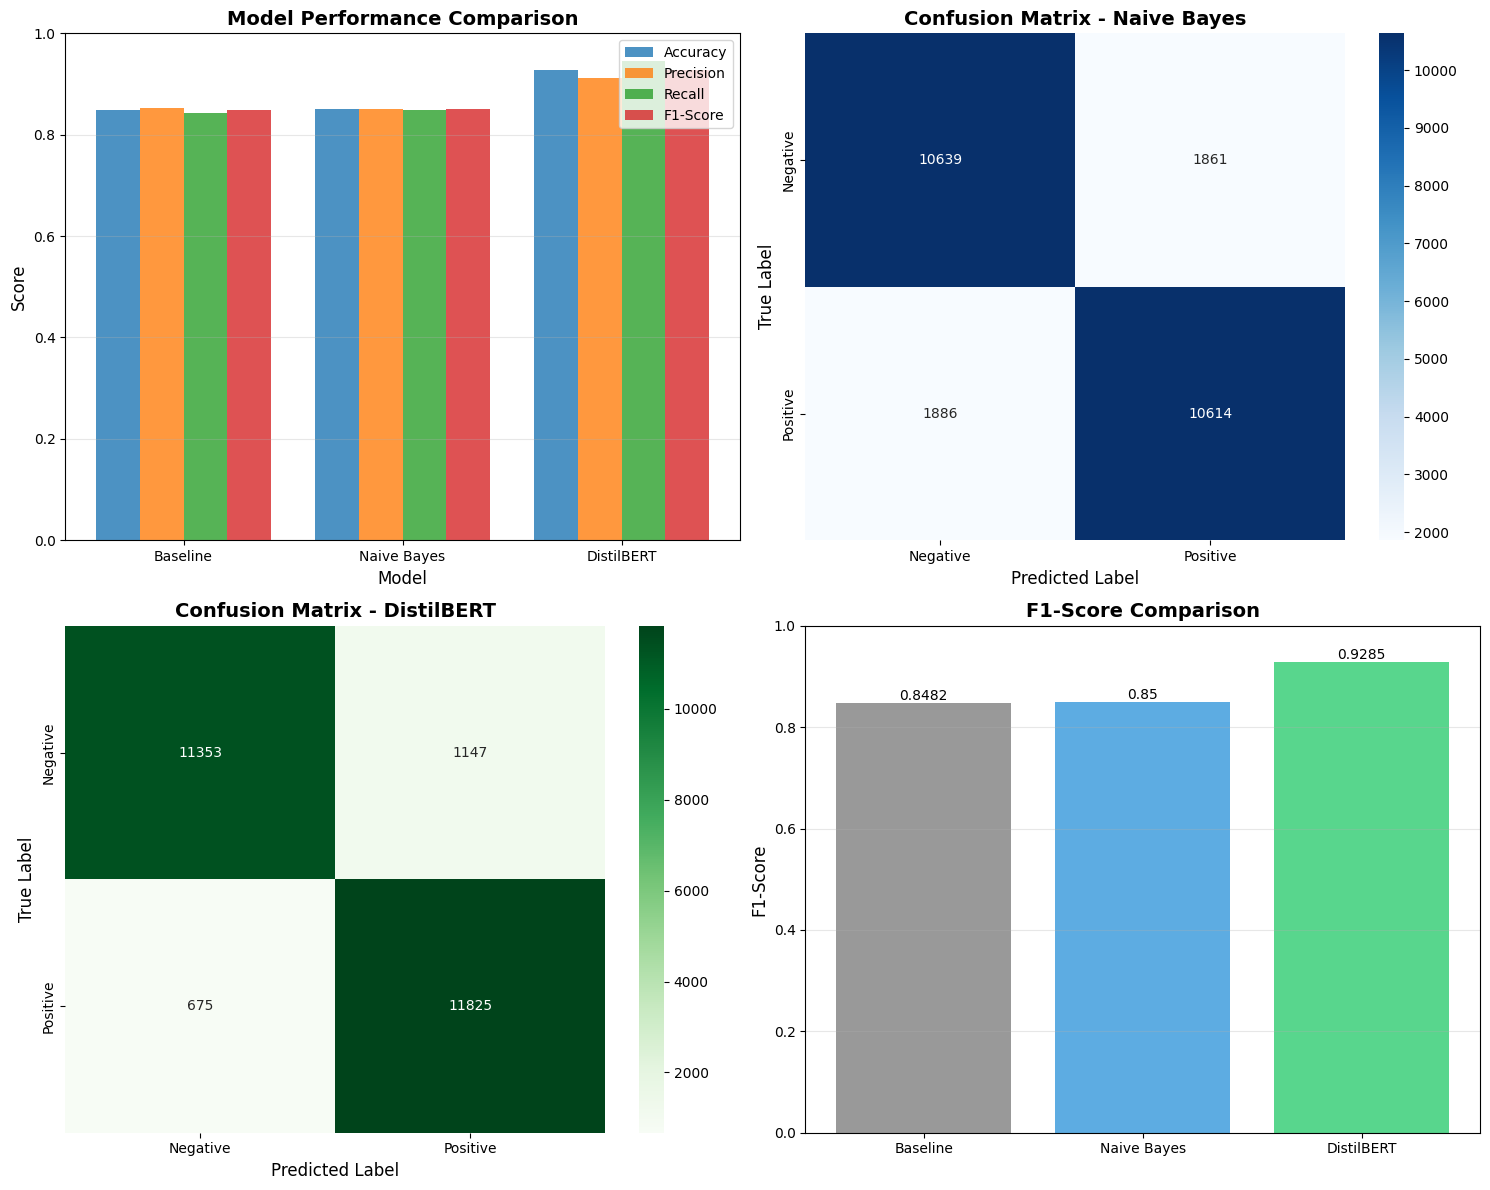


Visualization saved as 'model_comparison.png'
Include this figure in your report!


In [ ]:
#Create visualizations
#Creating comparison charts and confusion matrices

# Create a figure with 4 subplots arranged in 2 rows and 2 columns
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# chart 1: Bar chart comparing all metrics across all models
ax1 = axes[0, 0]
x = np.arange(len(results_df))# Create x-axis positions for each model (0, 1, 2 for Baseline, NB, BERT)
width = 0.2

# Create 4 sets of bars, one for each metric
ax1.bar(x - width*1.5, results_df["Accuracy"], width, label="Accuracy", alpha=0.8)
ax1.bar(x - width*0.5, results_df["Precision"], width, label="Precision", alpha=0.8)
ax1.bar(x + width*0.5, results_df["Recall"], width, label="Recall", alpha=0.8)
ax1.bar(x + width*1.5, results_df["F1-Score"], width, label="F1-Score", alpha=0.8)


ax1.set_xlabel("Model", fontsize=12)
ax1.set_ylabel("Score", fontsize=12)
ax1.set_title("Model Performance Comparison", fontsize=14, fontweight="bold")
ax1.set_xticks(x)
ax1.set_xticklabels(results_df["Model"])
ax1.legend()
ax1.set_ylim([0, 1])
ax1.grid(axis="y", alpha=0.3)

# chart 2: Simple bar chart showing F1-Score for each model
ax2 = axes[0, 1]
bars = ax2.bar(results_df["Model"], results_df["F1-Score"], color=["#7E7D7D", "#38abf8", "#38f386"], alpha=0.8)

ax2.set_ylabel("F1-Score", fontsize=12)
ax2.set_title("F1-Score Comparison", fontsize=14, fontweight="bold")
ax2.set_ylim([0, 1])
ax2.grid(axis="y", alpha=0.3)

# Add text labels on top of each bar showing exact F1-score value
for bar in bars:
	height = bar.get_height()
	ax2.text(bar.get_x() + bar.get_width()/2., height, round(height, 4),ha="center", va="bottom", fontsize=10)



# chart 3: Confusion matrix heatmap for Naive Bayes
ax33 = axes[1, 0]

# Create heatmap using seaborn
# nb_cm: confusion matrix data (2x2 array)
sns.heatmap(nb_cm, annot=True, fmt="d", cmap="Greens", ax=ax33, 
			xticklabels=["Negative", "Positive"], 
			yticklabels=["Negative", "Positive"])

ax33.set_title("Confusion Matrix - Naive Bayes", fontsize=14, fontweight="bold")
ax33.set_ylabel("True Label", fontsize=12)
ax33.set_xlabel("Predicted Label", fontsize=12)

#Chart 4: Confusion matrix heatmap for DistilBERT
ax4 = axes[1, 1]

# Similar to Chart 2 but with BERT data
sns.heatmap(bert_cm, annot=True, fmt="d", cmap="Greens", ax=ax4,
			xticklabels=["Negative", "Positive"], 
			yticklabels=["Negative", "Positive"])

ax4.set_title("Confusion Matrix - DistilBERT", fontsize=14, fontweight="bold")
ax4.set_ylabel("True Label", fontsize=12)
ax4.set_xlabel("Predicted Label", fontsize=12)



plt.tight_layout()

plt.savefig("model_comparison.png", dpi=300, bbox_inches="tight")

plt.show()

In [ ]:
## 9. Performance Analysis & Comparative Discussion (200-500 words)
[Analyze results, discuss why BERT won, tradeoffs]

## 10. Project Summary and Reflections (200-400 words)
[What you learned, future work, transferability]

9. Performance Analysis & Comparative Discussion (200-500 words) 

What to write: Look at the charts you generated in Cell 19.

Compare: "The Baseline achieved ~85%, while DistilBERT achieved ~93%."

Analyze: The 8% gain proves that "context matters" in sentiment analysis (e.g., catching sarcasm or double negatives).

Trade-off: Discuss that the Baseline trained in 5 seconds, while BERT took 15-20 minutes on a GPU. Is the 8% gain worth the cost? (Argue yes or no).

10. Project Summary and Reflections (200-400 words) 

What to write:

Reflection: Working with GPUs and environment setup (CUDA) was the hardest part.

Future Work: You could try a larger model (RoBERTa) or different domains (like Twitter/X data) to see if the model generalizes.